<h1><center> Electron Energy Flux Prediction </center></h1>
<h2><center> Part 2. Modeling </center></h2>


### Importing libraries

In [1]:
%%capture
# Setting random seed
from numpy.random import seed
seed(40)
import tensorflow as tf
tf.random.set_seed(50)

# File system manangement
import time, psutil, os, gc

# Progress bar for loops
!pip install tqdm
from tqdm import tqdm

# Mathematical functions
import math

# Data manipulation
import numpy as np
import pandas as pd

# Plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_theme()
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Train-test split and k-fold cross validation
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, GridSearchCV

# PCA
from sklearn.decomposition import PCA

# Regressors
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Deep learning
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Hyperparameter tuning
!pip install -q -U keras-tuner
import keras_tuner as kt
from keras_tuner import HyperModel, RandomSearch, Hyperband, BayesianOptimization

# Explainable AI
!pip install --quiet shap==0.39.0
import shap

# Warning suppression
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Runtime and memory usage
start = time.time()
process = psutil.Process(os.getpid())

# 1. Introduction

- [Data](#1.1.-Data)
- [Project Objective](#1.2.-Project-Objective)
- [Evaluation Metric](#1.3.-Evaluation-Metric)

## 1.1. Data

Source: https://www.kaggle.com/datasets/saurabhshahane/dmsp-particle-precipitation-aiready-data

In [3]:
# Loading the data
data = pd.read_csv('../input/dmsp-particle-precipitation-aiready-data/DMSP_final_training.csv')
print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data.shape)}).to_string())
print(" ")
data.head()

Memory usage        1098.54 MB
Dataset shape    (1945789, 74)
 


,Datetimes,SC_AACGM_LAT,ELE_TOTAL_ENERGY_FLUX,ID_SC,sin_ut,cos_ut,sin_doy,cos_doy,sin_SC_AACGM_LTIME,cos_SC_AACGM_LTIME,...,psw_30min,Bz_10min,By_10min,Bx_10min,AL_10min,AU_10min,SymH_10min,PC_10min,vsw_10min,psw_10min
0,1987-01-12 12:57:00,51.143220,6.464854e+08,6.0,-0.246153,-0.969231,0.205104,0.97874,0.996134,0.087845,...,3.61,1.25,6.52,-3.03,-36.0,19.0,4.0,0.71,364.4,3.09
1,1987-01-12 12:58:00,54.137207,7.884885e+08,6.0,-0.250380,-0.968148,0.205104,0.97874,0.992626,0.121216,...,3.61,1.25,6.52,-3.03,-36.0,19.0,4.0,0.71,364.4,3.09
2,1987-01-12 13:01:00,62.928176,1.404024e+09,6.0,-0.263031,-0.964787,0.205104,0.97874,0.968006,0.250928,...,3.66,1.51,6.42,-2.72,-61.0,25.0,3.0,0.77,356.0,2.96
3,1987-01-12 13:02:00,65.719631,6.078507e+10,6.0,-0.267238,-0.963630,0.205104,0.97874,0.950633,0.310316,...,3.66,1.51,6.42,-2.72,-61.0,25.0,3.0,0.77,356.0,2.96
4,1987-01-12 13:03:00,68.392364,1.229411e+12,6.0,-0.271440,-0.962455,0.205104,0.97874,0.924624,0.380881,...,3.66,1.51,6.42,-2.72,-61.0,25.0,3.0,0.77,356.0,2.96


## 1.2. Project Objective

The goal is to predict `ELE_TOTAL_ENERGY_FLUX`, which is a continuous variable, based on the features available in the dataset.

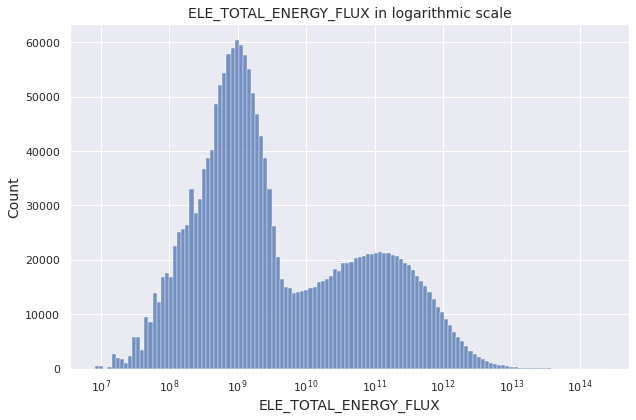

In [4]:
# Distribution of the target variable
plt.figure(figsize = (9, 6))
sns.histplot(data = data, x = 'ELE_TOTAL_ENERGY_FLUX', bins = math.floor(len(data)**(1/3)), log_scale = True)
plt.title("ELE_TOTAL_ENERGY_FLUX in logarithmic scale", fontsize = 14)
plt.xlabel("ELE_TOTAL_ENERGY_FLUX", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
plt.tight_layout()
plt.show()

## 1.3. Evaluation Metric

We use the trained models to compute the target variable, `ELE_TOTAL_ENERGY_FLUX`, for each row of the test dataset and evaluate the models in terms of [Root mean square error](https://en.wikipedia.org/wiki/Root-mean-square_deviation) (RMSE), [Mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) (MAE) and [Coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) ($R^2$).

RMSE is defined as a scaled version of the $L_2$-distance between the vector of predicted values and the vector of true values of the target variable in the test dataset,

$$RMSE := \sqrt{\frac{\lVert \mathbf{y_{\text{true}}} - \mathbf{y_{\text{pred}}} \rVert_{2}^{2}}{N_{\text{test}}}} = \sqrt{\frac{\sum_{i=1}^{N_{\text{test}}} \left(y_{\text{true},i} - y_{\text{pred},i}\right)^2}{N_{\text{test}}}},$$

MAE is defined as a scaled version of the $L_1$-distance between the vector of predicted values and the vector of true values of the target variable in the test dataset,

$$MAE := \frac{\lVert \mathbf{y_{\text{true}}} - \mathbf{y_{\text{pred}}} \rVert_{1}}{N_{\text{test}}} = \frac{\sum_{i=1}^{N_{\text{test}}} \left\vert y_{\text{true},i} - y_{\text{pred},i} \right\vert}{N_{\text{test}}},$$

$R^2$ measures the proportion of variability within the target variable that can be explained by the model.

$$R^2 := 1 - \frac{SS_{res}}{SS_{tot}} = 1 - \frac{\sum_{i=1}^n \left(y_{\text{true},i} - y_{\text{pred},i}\right)^2}{\sum_{i=1}^n \left(y_{\text{true},i} - \bar{y}_{\text{true}}\right)^2},$$

where
- $N_{test} = $ Number of observations in the test dataset
- $\mathbf{y_{\text{pred}}} = \left(y_{\text{pred}, 1}, y_{\text{pred}, 2}, \cdots, y_{\text{pred}, N_{\text{test}}}\right)$
    - $y_{\text{pred}, i} = $ Predicted value of the target variable corresponding to the $i$-th row of the test dataset
- $\mathbf{y_{\text{true}}} = \left(y_{\text{true}, 1}, y_{\text{true}, 2}, \cdots, y_{\text{true}, N_{\text{test}}}\right)$
    - $y_{\text{true}, i} = $ True value of the target variable corresponding to the $i$-th row of the test dataset
    - $\bar{y}_{\text{true}} = \frac{1}{N_{\text{test}}} \sum_{i=1}^{N_{\text{test}}} y_{\text{true},i}$
- $\lVert \cdot \rVert_2$ denotes the $L_2$-norm given by $\lVert \mathbf{x} \rVert_2 = \sqrt{x_1^2+x_2^2+\cdots+x_n^2},$ for $\mathbf{x}=\left(x_1,x_2,\cdots,x_n\right) \in \mathbb{R}^n$
- $\lVert \cdot \rVert_1$ denotes the $L_1$-norm given by $\lVert \mathbf{x} \rVert_1 = \lvert x_1 \rvert + \lvert x_2 \rvert + \cdots + \lvert x_n \rvert,$ for $\mathbf{x}=\left(x_1,x_2,\cdots,x_n\right) \in \mathbb{R}^n$
- $SS_{tot}$ is the [total sum of squares](https://en.wikipedia.org/wiki/Total_sum_of_squares)
- $SS_{reg}$ is the [explained sum of squares](https://en.wikipedia.org/wiki/Explained_sum_of_squares)
- $SS_{res}$ is the [residual sum of squares](https://en.wikipedia.org/wiki/Residual_sum_of_squares)

# 2. Data Preprocessing

- [Feature Extraction from Datetimes](#2.1.-Feature-Extraction-from-Datetimes)
- [Log-transformation of the Target](#2.2.-Log-transformation-of-the-Target)
- [Train-Test Split](#2.3.-Train-Test-Split)
- [Normalization](#2.4.-Normalization)
- [Principle Component Analysis](#2.5.-Principle-Component-Analysis-(PCA))

## 2.1. Feature Extraction from Datetimes

In [5]:
# Creating new features from the Datetimes column
data['year'] = data['Datetimes'].apply(lambda x: float(x.split()[0].split('-')[0]))
data['month'] = data['Datetimes'].apply(lambda x: float(x.split()[0].split('-')[1]))
data['day'] = data['Datetimes'].apply(lambda x: float(x.split()[0].split('-')[2]))
data['hour'] = data['Datetimes'].apply(lambda x: float(x.split()[1].split(':')[0]))
data['minute'] = data['Datetimes'].apply(lambda x: float(x.split()[1].split(':')[1]))
data['second'] = data['Datetimes'].apply(lambda x: float(x.split()[1].split(':')[2]))

In [6]:
# Dropping the 'Datetimes' column
data.drop(['Datetimes'], axis = 1, inplace = True)

In [7]:
# Rearranging the columns
cols = data.columns.tolist()
cols = cols[-6:] + cols[:-6]
data = data[cols]

In [8]:
# Printing the new features
print(pd.Series({"Shape": "{}".format(data[['year', 'month', 'day', 'hour', 'minute', 'second']].shape)}).to_string())
print(" ")
data[['year', 'month', 'day', 'hour', 'minute', 'second']].head()

Shape    (1945789, 6)
 


,year,month,day,hour,minute,second
0,1987.0,1.0,12.0,12.0,57.0,0.0
1,1987.0,1.0,12.0,12.0,58.0,0.0
2,1987.0,1.0,12.0,13.0,1.0,0.0
3,1987.0,1.0,12.0,13.0,2.0,0.0
4,1987.0,1.0,12.0,13.0,3.0,0.0


In [9]:
# Statistical description of the new features
data[['year', 'month', 'day', 'hour', 'minute', 'second']].describe()

,year,month,day,hour,minute,second
count,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1945789.0
mean,2.007305e+03,6.702163e+00,1.559880e+01,1.156175e+01,2.951051e+01,0.0
std,4.294827e+00,3.492987e+00,8.784479e+00,6.927201e+00,1.728083e+01,0.0
min,1.987000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,2.004000e+03,4.000000e+00,8.000000e+00,6.000000e+00,1.500000e+01,0.0
50%,2.006000e+03,7.000000e+00,1.600000e+01,1.200000e+01,3.000000e+01,0.0
75%,2.011000e+03,1.000000e+01,2.300000e+01,1.800000e+01,4.400000e+01,0.0
max,2.014000e+03,1.200000e+01,3.100000e+01,2.300000e+01,5.900000e+01,0.0


In [10]:
# Dropping the constant 'second' column
data.drop(['second'], axis = 1, inplace = True)

## 2.2. Log-transformation of the Target

In [11]:
# Log-transforming the target
data['ELE_TOTAL_ENERGY_FLUX_LOG'] = data['ELE_TOTAL_ENERGY_FLUX'].apply(lambda x: np.log(x))

In [12]:
# Dropping the original target
data.drop(['ELE_TOTAL_ENERGY_FLUX'], axis = 1, inplace = True)

## 2.3. Train-Test Split

In [13]:
# Train-test split
X = data.drop('ELE_TOTAL_ENERGY_FLUX_LOG', axis = 1) # Independent variables
y = data['ELE_TOTAL_ENERGY_FLUX_LOG'] # Target variable (log-transformed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

In [14]:
# Resetting index
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

In [15]:
# Training set features
print(pd.Series({"Shape": "{}".format(X_train.shape)}).to_string())
print(" ")
X_train.head()

Shape    (1556631, 77)
 


,year,month,day,hour,minute,SC_AACGM_LAT,ID_SC,sin_ut,cos_ut,sin_doy,...,psw_30min,Bz_10min,By_10min,Bx_10min,AL_10min,AU_10min,SymH_10min,PC_10min,vsw_10min,psw_10min
0,2001.0,9.0,29.0,8.0,26.0,52.919448,13.0,0.803857,-0.594823,-0.999546,...,1.56,-2.43,0.23,-4.43,-263.0,232.0,-48.0,4.38,503.3,1.68
1,2001.0,12.0,9.0,2.0,48.0,68.681389,13.0,0.669131,0.743145,-0.369725,...,0.67,2.94,1.99,4.61,-4.0,14.0,-4.0,-0.11,370.6,0.49
2,2006.0,10.0,16.0,11.0,40.0,59.856034,13.0,0.087156,-0.996195,-0.965740,...,1.49,0.11,2.29,2.98,-117.0,81.0,-18.0,1.79,474.3,1.48
3,2012.0,5.0,10.0,16.0,0.0,53.663545,18.0,-0.866025,-0.500000,0.774884,...,1.36,1.52,-3.43,1.92,-168.0,39.0,-18.0,3.67,601.8,1.44
4,2007.0,8.0,18.0,6.0,20.0,74.910079,15.0,0.996195,-0.087156,-0.729558,...,1.58,2.39,-3.02,2.13,0.0,15.0,-1.0,0.18,381.0,1.70


In [16]:
# Test set features
print(pd.Series({"Shape": "{}".format(X_test.shape)}).to_string())
print(" ")
X_test.head()

Shape    (389158, 77)
 


,year,month,day,hour,minute,SC_AACGM_LAT,ID_SC,sin_ut,cos_ut,sin_doy,...,psw_30min,Bz_10min,By_10min,Bx_10min,AL_10min,AU_10min,SymH_10min,PC_10min,vsw_10min,psw_10min
0,2013.0,4.0,25.0,22.0,45.0,76.687114,17.0,-0.321439,0.946930,0.917584,...,2.09,0.70,4.94,4.58,-120.0,84.0,-25.0,1.31,533.1,2.22
1,2010.0,5.0,28.0,10.0,38.0,59.519524,17.0,0.350207,-0.936672,0.559589,...,5.60,2.59,-4.43,-3.80,-35.0,75.0,16.0,-0.59,386.6,5.51
2,2014.0,7.0,26.0,13.0,51.0,60.118979,17.0,-0.465615,-0.884988,-0.409356,...,1.98,3.49,0.48,-2.34,-35.0,32.0,-16.0,-0.55,383.0,1.95
3,2007.0,11.0,16.0,11.0,33.0,48.047607,15.0,0.117537,-0.993068,-0.699458,...,1.82,2.43,0.30,4.45,-32.0,26.0,0.0,0.47,546.9,2.14
4,1987.0,6.0,1.0,14.0,34.0,57.654939,6.0,-0.622515,-0.782608,0.501242,...,4.01,-2.42,0.77,-3.89,-91.0,66.0,-3.0,1.40,363.1,3.96


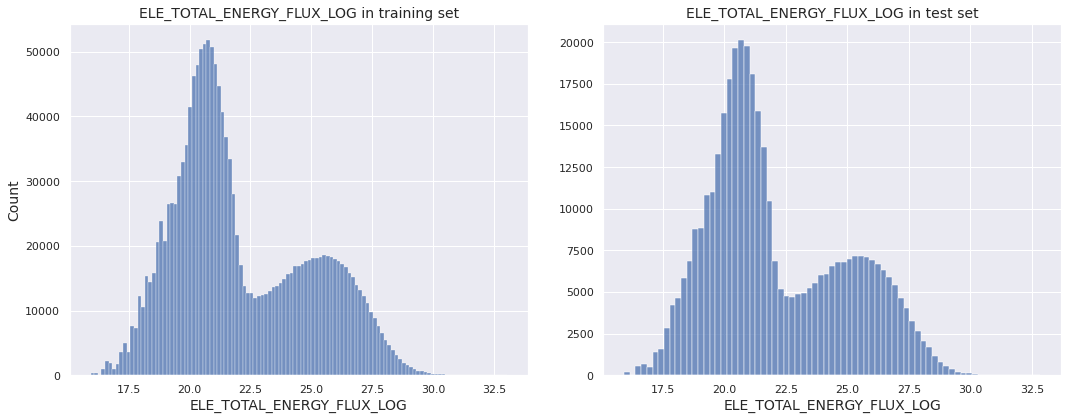

In [17]:
# Distribution of the target variable (in logarithmic scale) in the training set and test set
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharey = False)
sns.histplot(x = y_train, bins = math.floor(len(y_train)**(1/3)), ax = ax[0])
ax[0].set_title("ELE_TOTAL_ENERGY_FLUX_LOG in training set", fontsize = 14)
ax[0].set_xlabel("ELE_TOTAL_ENERGY_FLUX_LOG", fontsize = 14)
ax[0].set_ylabel("Count", fontsize = 14)
sns.histplot(x = y_test, bins = math.floor(len(y_test)**(1/3)), ax = ax[1])
ax[1].set_title("ELE_TOTAL_ENERGY_FLUX_LOG in test set", fontsize = 14)
ax[1].set_xlabel("ELE_TOTAL_ENERGY_FLUX_LOG", fontsize = 14)
ax[1].set_ylabel(" ", fontsize = 14)
plt.tight_layout()
plt.show()

## 2.4. Normalization

In [18]:
# Min-max normalization of predictors in the training set
for col in X_train.columns:
    if X_train[col].dtypes == 'int64' or X_train[col].dtypes == 'float64': # Checking if the column is numerical
        if X_train[col].nunique() > 1: # Checking if the column is non-constant
            X_train[col] = (X_train[col] - X_train[col].min()) / (X_train[col].max() - X_train[col].min())

print(pd.Series({"Shape": "{}".format(X_train.shape)}).to_string())
print(" ")
X_train.head()

Shape    (1556631, 77)
 


,year,month,day,hour,minute,SC_AACGM_LAT,ID_SC,sin_ut,cos_ut,sin_doy,...,psw_30min,Bz_10min,By_10min,Bx_10min,AL_10min,AU_10min,SymH_10min,PC_10min,vsw_10min,psw_10min
0,0.518519,0.727273,0.933333,0.347826,0.440678,0.176052,0.583333,0.901928,0.202589,0.000222,...,0.032986,0.103993,0.475835,0.241091,0.714424,0.518447,0.400922,0.471876,0.423299,0.036292
1,0.518519,1.000000,0.266667,0.086957,0.813559,0.526447,0.583333,0.834565,0.871572,0.315136,...,0.014046,0.187094,0.510413,0.405455,0.965150,0.095146,0.603687,0.302378,0.231978,0.010275
2,0.703704,0.818182,0.500000,0.478261,0.677966,0.330256,0.583333,0.543578,0.001903,0.017126,...,0.031496,0.143299,0.516306,0.375818,0.855760,0.225243,0.539171,0.374103,0.381488,0.031920
3,0.925926,0.363636,0.300000,0.695652,0.000000,0.192594,1.000000,0.066987,0.250000,0.887446,...,0.028730,0.165119,0.403929,0.356545,0.806389,0.143689,0.539171,0.445074,0.565311,0.031045
4,0.740741,0.636364,0.566667,0.260870,0.338983,0.664914,0.750000,0.998097,0.456422,0.135218,...,0.033411,0.178582,0.411984,0.360364,0.969022,0.097087,0.617512,0.313326,0.246972,0.036729


In [19]:
# Min-max normalization of predictors in the test set
for col in X_test.columns:
    if X_test[col].dtypes == 'int64' or X_test[col].dtypes == 'float64': # Checking if the column is numerical
        if X_test[col].nunique() > 1: # Checking if the column is non-constant
            X_test[col] = (X_test[col] - X_test[col].min()) / (X_test[col].max() - X_test[col].min())

print(pd.Series({"Shape": "{}".format(X_test.shape)}).to_string())
print(" ")
X_test.head()

Shape    (389158, 77)
 


,year,month,day,hour,minute,SC_AACGM_LAT,ID_SC,sin_ut,cos_ut,sin_doy,...,psw_30min,Bz_10min,By_10min,Bx_10min,AL_10min,AU_10min,SymH_10min,PC_10min,vsw_10min,psw_10min
0,0.962963,0.272727,0.800000,0.956522,0.762712,0.704613,0.916667,0.339280,0.973465,0.958796,...,0.051244,0.165937,0.568369,0.591640,0.852856,0.232510,0.539216,0.355983,0.466263,0.048098
1,0.851852,0.363636,0.900000,0.434783,0.644068,0.322864,0.916667,0.675104,0.031664,0.779797,...,0.137719,0.197776,0.384283,0.367095,0.935140,0.213992,0.740196,0.284258,0.255046,0.120026
2,1.000000,0.545455,0.833333,0.565217,0.864407,0.336194,0.916667,0.267193,0.057506,0.295320,...,0.048534,0.212938,0.480747,0.406217,0.935140,0.125514,0.583333,0.285768,0.249856,0.042195
3,0.740741,0.909091,0.500000,0.478261,0.559322,0.067767,0.750000,0.558769,0.003466,0.150268,...,0.044592,0.195081,0.477210,0.588156,0.938045,0.113169,0.661765,0.324273,0.486159,0.046349
4,0.000000,0.454545,0.000000,0.608696,0.576271,0.281402,0.000000,0.188743,0.108696,0.750623,...,0.098546,0.113376,0.486444,0.364684,0.880929,0.195473,0.647059,0.359381,0.221165,0.086139


## 2.5. Principle Component Analysis (PCA)

In [20]:
# PCA-fitting the training set
pca = PCA(n_components = 20)
pca.fit(X_train)

PCA(n_components=20)

In [21]:
# PCA summary
print(pd.Series({"Number of components": "{}".format(pca.n_components_),
                 "Explained variance ratio": "{:.4g}%".format(pca.explained_variance_ratio_.sum()*100)
                }).to_string())

Number of components            20
Explained variance ratio    96.44%


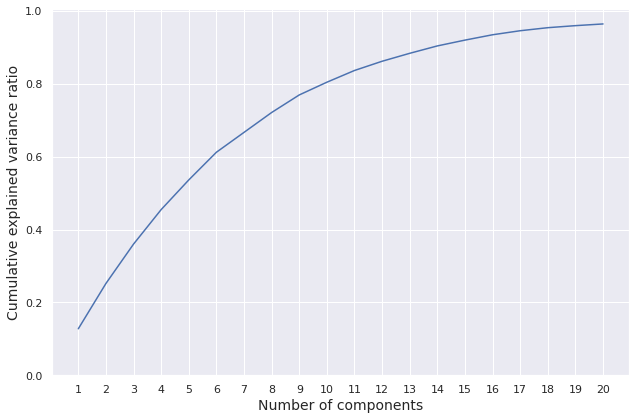

In [22]:
# Cumulative explained variance ratio
plt.figure(figsize = (9, 6))
sns.lineplot(x = np.arange(pca.n_components_) + 1, y = np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components", fontsize = 14)
plt.xticks(np.arange(pca.n_components_) + 1)
plt.ylabel("Cumulative explained variance ratio", fontsize = 14)
plt.yticks(np.arange(0, 1.1, 0.2))
plt.tight_layout()
plt.show()

In [23]:
# Correlation structure of components and features
print(pd.Series({"Shape": "{}".format(pd.DataFrame(pca.components_, columns = X_train.columns).shape)}).to_string())
print(" ")
pd.DataFrame(pca.components_, columns = X_train.columns).head()

Shape    (20, 77)
 


,year,month,day,hour,minute,SC_AACGM_LAT,ID_SC,sin_ut,cos_ut,sin_doy,...,psw_30min,Bz_10min,By_10min,Bx_10min,AL_10min,AU_10min,SymH_10min,PC_10min,vsw_10min,psw_10min
0,0.007870,-0.204965,-0.000906,-0.557795,0.004520,-0.130356,0.002733,0.689770,0.039383,0.227679,...,0.000032,0.000600,-0.000102,-0.004281,0.013793,0.027542,-0.008423,-0.000486,0.026556,-0.000100
1,0.058558,-0.629977,-0.016542,0.183926,-0.001523,0.042907,0.034557,-0.224299,-0.003006,0.697312,...,0.001651,-0.000719,0.000069,-0.017305,-0.007215,-0.000735,-0.002131,0.001109,0.035109,0.001679
2,0.030239,0.007308,0.008059,-0.177579,0.000269,0.000715,0.027643,0.216804,0.091974,-0.002326,...,-0.000686,-0.000390,-0.000969,0.000456,0.019016,-0.010818,0.005711,-0.003049,-0.036123,-0.000701
3,-0.113729,0.031372,-0.022584,-0.006817,0.003681,0.016315,-0.099592,0.004236,-0.035075,-0.048386,...,0.004041,0.003712,-0.000067,-0.000690,-0.067843,0.100811,-0.040391,0.013961,0.202841,0.003964
4,-0.000806,-0.002404,-0.003617,-0.066184,-0.001318,0.036861,-0.000399,0.067733,-0.971349,0.009090,...,-0.000422,0.002036,0.000017,0.006939,-0.016975,0.000164,-0.004300,0.002818,-0.000151,-0.000362


In [24]:
# PCA-transforming the training set features
X_train = pd.DataFrame(pca.transform(X_train))
print(pd.Series({"Shape": "{}".format(X_train.shape)}).to_string())
print(" ")
X_train.head()

Shape    (1556631, 20)
 


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.450660,-0.615163,-0.360683,0.527870,0.253479,0.454448,0.167356,0.350813,-0.392485,-0.107808,0.795571,-0.032360,-0.114972,-0.058070,-0.181003,0.108877,-0.135812,-0.083914,0.124564,0.017574
1,0.375201,-0.622745,0.331111,-0.407754,-0.364675,0.272344,-0.368186,-0.167058,-0.262704,0.328371,-0.076166,0.288667,0.122691,0.163621,0.294295,-0.124242,0.014338,-0.037404,0.019694,-0.029393
2,-0.248562,-0.463250,0.423296,0.261399,0.550077,0.285747,-0.176820,0.027226,-0.067487,-0.157836,0.127074,0.029331,0.078076,0.145826,-0.066477,0.013623,-0.073353,-0.046721,-0.120629,-0.022003
3,-0.320697,0.639458,0.229834,0.725872,0.204942,0.244508,0.436355,-0.305957,-0.311245,-0.272470,-0.226441,-0.376405,-0.191734,0.097082,0.158540,-0.142998,0.010526,-0.111168,-0.016989,-0.088394
4,0.321536,-0.479157,-0.025147,0.108801,0.125863,-0.316508,0.185233,0.067830,0.552133,0.041273,-0.240360,0.055890,-0.162276,0.022299,-0.125381,0.157155,-0.043955,-0.030762,0.011333,0.074102


In [25]:
# PCA transforming the test set features
X_test = pd.DataFrame(pca.transform(X_test))
print(pd.Series({"Shape": "{}".format(X_test.shape)}).to_string())
print(" ")
X_test.head()

Shape    (389158, 20)
 


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.061005,0.627316,-0.231939,0.398505,-0.588724,0.236077,-0.166219,0.357988,-0.378950,0.395881,-0.008776,-0.370785,0.186803,0.362299,0.170860,0.225146,-0.075574,0.127732,-0.061215,0.088811
1,0.115359,0.291809,0.368049,0.232131,0.500764,-0.505285,-0.015781,0.486388,0.095227,-0.224244,-0.109911,-0.042142,-0.183327,-0.017095,0.060688,0.076660,0.307495,0.131736,-0.095677,0.131470
2,-0.373103,-0.025490,0.255526,0.378662,0.444747,-0.433502,-0.251650,0.460561,0.008242,-0.228408,0.033659,-0.232126,0.152127,-0.119734,-0.111571,-0.074421,-0.165310,0.391943,-0.061099,0.050991
3,-0.163032,-0.408079,0.477103,0.157810,0.521320,0.604858,-0.061269,-0.007148,-0.326870,-0.314479,-0.292230,-0.047248,0.022133,0.106434,0.055753,0.005409,0.184319,-0.029620,-0.139153,0.004562
4,-0.340939,0.286959,0.124634,0.450149,0.393564,-0.352766,-0.200221,-0.408178,0.119238,-0.271780,0.286671,1.077538,0.020841,-0.102196,0.203603,-0.095082,0.074706,-0.120751,-0.107839,-0.060537


# 3. Baseline Neural Network

In [26]:
# Adding layers to sequential model
model = Sequential()
model.add(Dense(units = 128, input_dim = len(X_train.columns), activation = 'relu'))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(units = 16, activation = 'relu'))
model.add(Dense(units = 4, activation = 'relu'))
model.add(Dense(units = 1, activation = 'linear'))
model.summary()

2022-04-29 16:39:08.399404: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2688      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 13,625
Trainable params: 13,625
Non-trainable params: 0
____________________________________________________

In [27]:
# Specifying loss function and optimizer
adam_opt = Adam(learning_rate = 0.001,
                beta_1 = 0.9,
                beta_2 = 0.999,
                epsilon = 1e-07,
                amsgrad = False)
sgd_opt = SGD(learning_rate = 0.01, momentum = 0.9, nesterov = False)
model.compile(loss = 'mean_squared_error', optimizer = adam_opt)

In [28]:
%%time
# Fitting the model
history = model.fit(X_train, y_train, epochs = 120, batch_size = 32, validation_split = 0.2)

2022-04-29 16:39:09.505013: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/120
38916/38916 [==============================] - 111s 3ms/step - loss: 3.7118 - val_loss: 2.7880
Epoch 2/120
38916/38916 [==============================] - 110s 3ms/step - loss: 2.6820 - val_loss: 2.5626
Epoch 3/120
38916/38916 [==============================] - 107s 3ms/step - loss: 2.5859 - val_loss: 2.5755
Epoch 4/120
38916/38916 [==============================] - 106s 3ms/step - loss: 2.5348 - val_loss: 2.5215
Epoch 5/120
38916/38916 [==============================] - 107s 3ms/step - loss: 2.5037 - val_loss: 2.4751
Epoch 6/120
38916/38916 [==============================] - 110s 3ms/step - loss: 2.4781 - val_loss: 2.4598
Epoch 7/120
38916/38916 [==============================] - 106s 3ms/step - loss: 2.4601 - val_loss: 2.4507
Epoch 8/120
38916/38916 [==============================] - 105s 3ms/step - loss: 2.4475 - val_loss: 2.4351
Epoch 9/120
38916/38916 [==============================] - 107s 3ms/step - loss: 2.4364 - val_loss: 2.4763
Epoch 10/120
38916/38916 [===========

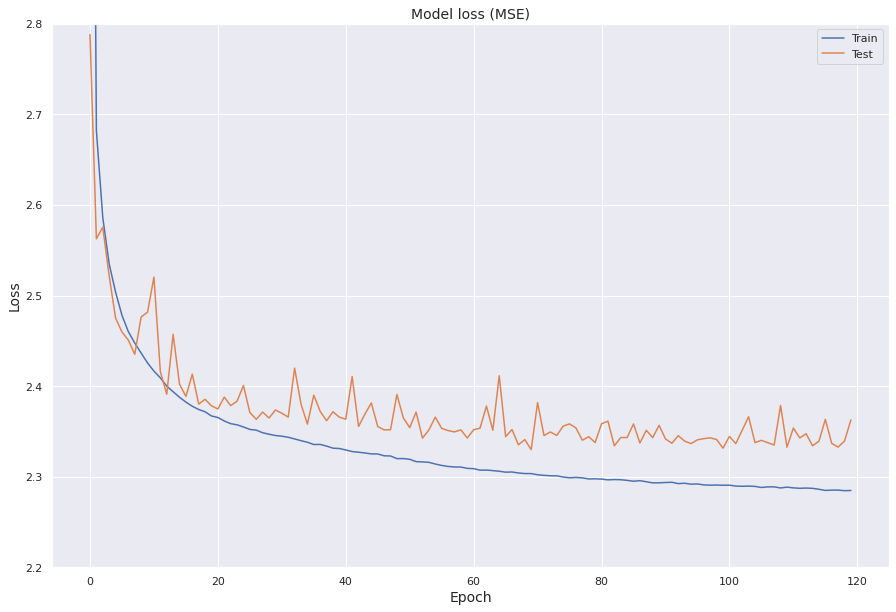

In [29]:
# Visualization of model loss
plt.figure(figsize = (15, 10))
plt.title('Model loss (MSE)', fontsize = 14)
sns.lineplot(data = history.history['loss'], label = 'Train')
sns.lineplot(data = history.history['val_loss'], label = 'Test')
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)
plt.ylim(2.2, 2.8)
plt.legend()
plt.savefig('mse.jpg')
plt.show()

In [30]:
# Prediction on the training set and the test set
y_train_pred = model.predict(X_train).flatten()
y_test_pred = model.predict(X_test).flatten()

In [31]:
# Function to plot the error distribution
def error_dist(y_true, y_pred, figsize = (9, 6)):
    if len(y_true) != len(y_pred):
        raise Exception("The number of true values and the number of predicted values do not match.")
    else:
        plt.figure(figsize = figsize)
        sns.histplot(x = y_true - y_pred, bins = math.floor(len(y_true)**(1/3)))
        plt.title("Error distribution")
        plt.xlabel("error")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

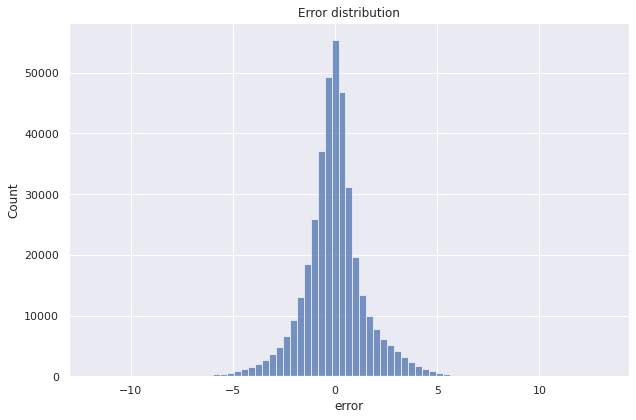

In [32]:
# Error distribution
error_dist(y_test, y_test_pred)

In [33]:
# Function to compute dataframe of evaluation metrics
def eval_df(y_train, y_train_pred, y_test, y_test_pred):
    eval_dict_train = pd.Series({'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
                                 'MAE': mean_absolute_error(y_train, y_train_pred),
                                 'R2': r2_score(y_train, y_train_pred)})
    eval_dict_test = pd.Series({'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
                                'MAE': mean_absolute_error(y_test, y_test_pred),
                                'R2': r2_score(y_test, y_test_pred)})
    eval_df_train = pd.DataFrame(eval_dict_train.items(), columns = ['Metric', 'Train'])
    eval_df_train.set_index('Metric', inplace = True)
    eval_df_test = pd.DataFrame(eval_dict_test.items(), columns = ['Metric', 'Test'])
    eval_df_test.set_index('Metric', inplace = True)
    eval_df_concat = pd.concat([eval_df_train, eval_df_test], axis = 1, sort = False).reset_index()
    eval_df_concat.rename(columns = {'index': 'Metric'})
    return eval_df_concat

In [34]:
# Evaluation metrics
display(eval_df(y_train, y_train_pred, y_test, y_test_pred))

,Metric,Train,Test
0,RMSE,1.518847,1.532756
1,MAE,1.065321,1.076696
2,R2,0.705653,0.699132


# 4. Hyperparameter Tuning

In [35]:
# Building the model
def model_builder(hp):
    model = Sequential()
    model.add(Flatten(input_shape = (X_train.shape[1],)))

    # Tuning the number of units in the Dense layers
    hp_units = hp.Int('units', min_value = 128, max_value = 512, step = 128)
    
    # Adding layers to sequential model
    model.add(Dense(units = hp_units, activation = 'relu'))
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 16, activation = 'relu'))
    model.add(Dense(units = 4, activation = 'relu'))
    model.add(Dense(units = 1, activation = 'linear'))

    # Tuning the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values = [0.01, 0.001, 0.0001])
    
    # Model compilation
    model.compile(loss = 'mean_squared_error', optimizer = Adam(learning_rate = hp_learning_rate))

    return model

In [36]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder, objective = 'val_loss', max_epochs = 120, factor = 2, directory = 'dir_1')

In [37]:
# Tuning settings
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [38]:
# Searching for optimal hyperparameters
tuner.search(X_train, y_train, epochs = 120, validation_split = 0.2)
hp_tuned = tuner.get_best_hyperparameters()[0]

Trial 12 Complete [00h 03m 27s]
val_loss: 7.820208549499512

Best val_loss So Far: 2.549257516860962
Total elapsed time: 00h 42m 34s


In [39]:
# Building the model with optimal hyperparameters
model_tuned = tuner.hypermodel.build(hp_tuned)
model_tuned.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 20)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               2688      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [40]:
# Model fitting
history_tuned = model_tuned.fit(X_train, y_train, epochs = 120, validation_split = 0.2)

Epoch 1/120
38916/38916 [==============================] - 100s 3ms/step - loss: 4.3332 - val_loss: 3.0339
Epoch 2/120
38916/38916 [==============================] - 99s 3ms/step - loss: 2.7867 - val_loss: 2.6413
Epoch 3/120
38916/38916 [==============================] - 103s 3ms/step - loss: 2.6762 - val_loss: 2.6007
Epoch 4/120
38916/38916 [==============================] - 102s 3ms/step - loss: 2.6173 - val_loss: 2.5669
Epoch 5/120
38916/38916 [==============================] - 102s 3ms/step - loss: 2.5816 - val_loss: 2.5641
Epoch 6/120
38916/38916 [==============================] - 103s 3ms/step - loss: 2.5535 - val_loss: 2.4924
Epoch 7/120
38916/38916 [==============================] - 103s 3ms/step - loss: 2.5327 - val_loss: 2.5243
Epoch 8/120
38916/38916 [==============================] - 103s 3ms/step - loss: 2.5174 - val_loss: 2.4743
Epoch 9/120
38916/38916 [==============================] - 102s 3ms/step - loss: 2.5033 - val_loss: 2.4745
Epoch 10/120
38916/38916 [============

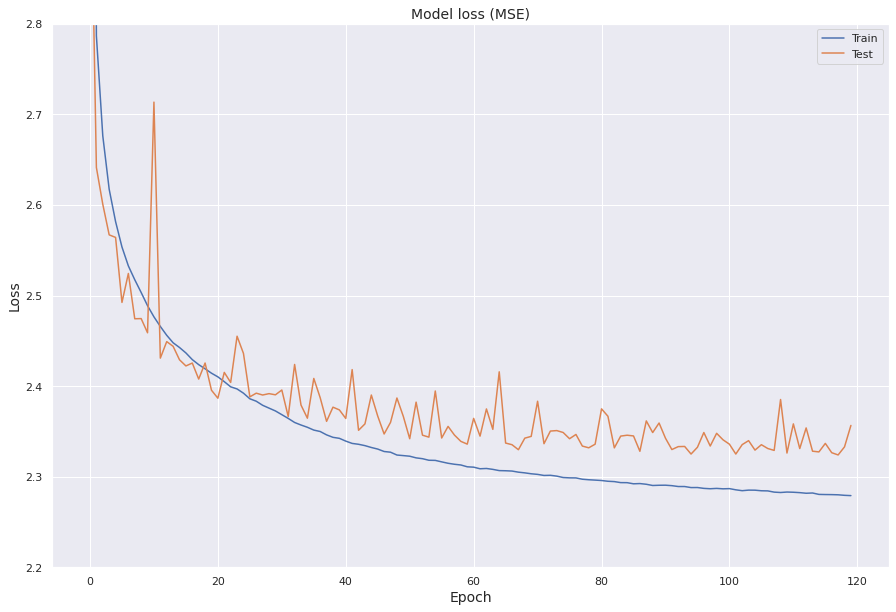

In [41]:
# Visualization of model loss
plt.figure(figsize = (15, 10))
plt.title('Model loss (MSE)', fontsize = 14)
sns.lineplot(data = history_tuned.history['loss'], label = 'Train')
sns.lineplot(data = history_tuned.history['val_loss'], label = 'Test')
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)
plt.ylim(2.2, 2.8)
plt.legend()
plt.savefig('mse_tuned.jpg')
plt.show()

In [42]:
# Prediction on the training set and the test set
y_train_pred_tuned = model_tuned.predict(X_train).flatten()
y_test_pred_tuned = model_tuned.predict(X_test).flatten()

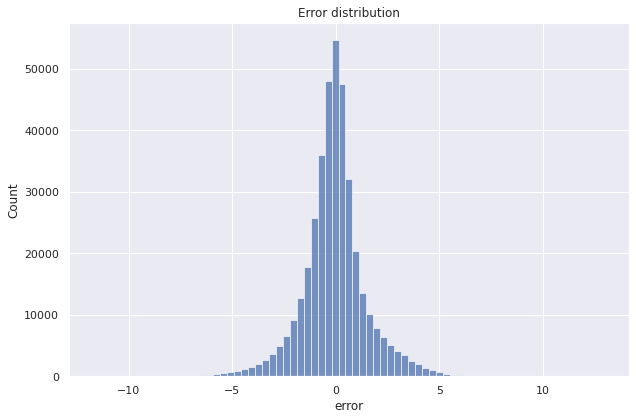

In [43]:
# Error distribution
error_dist(y_test, y_test_pred_tuned)

In [44]:
# Evaluation metrics
display(eval_df(y_train, y_train_pred_tuned, y_test, y_test_pred_tuned))

,Metric,Train,Test
0,RMSE,1.517044,1.531904
1,MAE,1.063424,1.075939
2,R2,0.706351,0.699466


# 5. Explainable AI

In [45]:
# Loading JavaScript library
shap.initjs()

# Sampling from test data predictors
X_test_sample = X_test.sample(100)

# Predicted values corresponding to the sample
y_test_pred_tuned_sample = np.array(pd.Series(data = y_test_pred_tuned, index = X_test.index)[X_test_sample.index])

# Wrapper function
def wrap(X):
    return model_tuned.predict(X).flatten()

# Explainer
explainer = shap.KernelExplainer(wrap, X_test_sample)

# Computing SHAP values based on the sample
shap_values = explainer.shap_values(X_test_sample, nsamples = 500)

  0%|          | 0/100 [00:00<?, ?it/s]

## Global interpretation

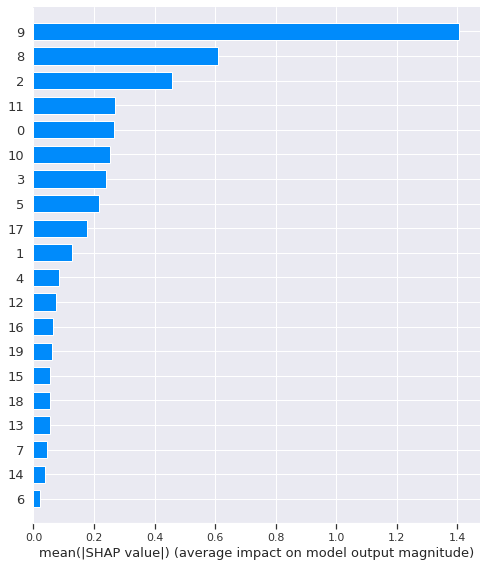

In [46]:
# Summary plot
shap.summary_plot(shap_values = shap_values, features = X_test_sample, plot_type = 'bar')

## Local interpretation

### Explaining single prediction

In [47]:
# Force plot
shap.initjs()
row = math.floor(len(X_test_sample)/2)
print(pd.Series({"Predicted value": y_test_pred_tuned_sample[row]}).to_string())
shap_values_row = explainer.shap_values(X_test_sample.iloc[row, :], nsamples = 500)
shap.force_plot(base_value = explainer.expected_value,
                shap_values = shap_values_row,
                features = X_test_sample.iloc[row, :],
                feature_names = X_test_sample.columns)

Predicted value    25.899044


Predicted value    25.899044


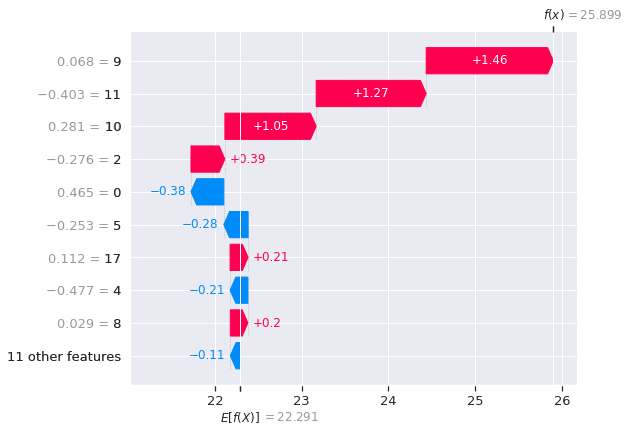

In [48]:
# Waterfall plot
print(pd.Series({"Predicted value": y_test_pred_tuned_sample[row]}).to_string())
shap.waterfall_plot(shap.Explanation(values = shap_values_row,
                                     base_values = explainer.expected_value,
                                     data = X_test_sample.iloc[row, :],
                                     feature_names = [str(x) for x in X_test_sample.columns.tolist()]))

Predicted value    25.899044


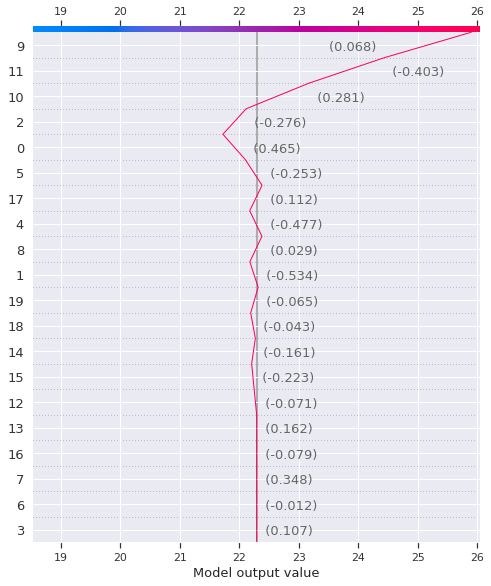

In [49]:
# Decision plot
print(pd.Series({"Predicted value": y_test_pred_tuned_sample[row]}).to_string())
shap.decision_plot(base_value = explainer.expected_value,
                   shap_values = shap_values_row,
                   features = X_test_sample.iloc[row, :],
                   feature_names = [str(x) for x in X_test_sample.columns.tolist()])

### Explaining multiple predictions

In [50]:
# Force plot
shap.initjs()
shap.force_plot(base_value = explainer.expected_value,
                shap_values = shap_values,
                features = X_test_sample,
                feature_names = X_test_sample.columns)

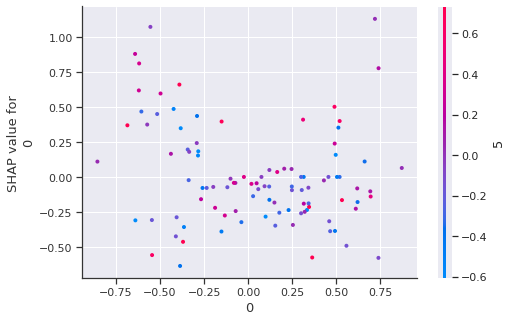

In [51]:
# Dependence plot for '0'
shap.dependence_plot(ind = 0, shap_values = shap_values, features = X_test_sample)

Predicted values
 
[21.183346 20.889162 21.64356  19.414095 26.336338 26.418718]
 


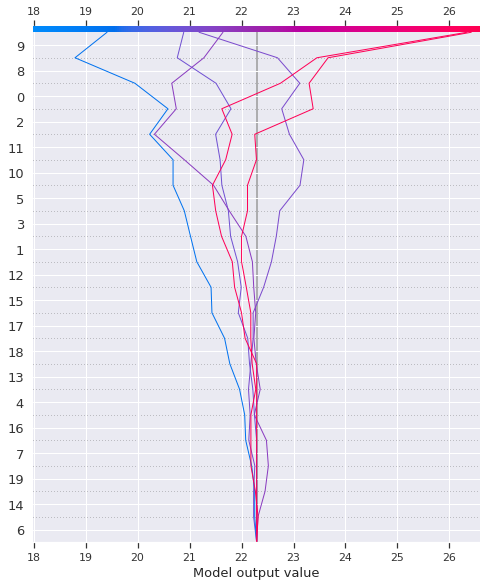

In [53]:
# Decision plot
print("Predicted values")
print(" ")
rows = [i*math.floor(len(X_test_sample)/6) for i in range(6)]
print(np.array(pd.Series(y_test_pred_tuned_sample)[rows]))
print(" ")
shap.decision_plot(base_value = explainer.expected_value, 
                   shap_values = shap_values[rows], 
                   features = X_test_sample.iloc[rows, :],
                   feature_names = [str(x) for x in X_test_sample.columns.tolist()])

In [54]:
# Runtime and memory usage
stop = time.time()
print(pd.Series({"Process runtime": "{:.2f} seconds".format(float(stop - start)),
                 "Process memory usage": "{:.2f} MB".format(float(process.memory_info()[0]/(1024*1024)))}).to_string())

Process runtime         28243.39 seconds
Process memory usage          7661.36 MB
